# MEI Demo

In [1]:
import os
import datajoint as dj
dj.config['database.host'] = os.environ['DJ_HOST']
dj.config['database.user'] = os.environ['DJ_USERNAME']
dj.config['database.password'] = os.environ['DJ_PASSWORD']
dj.config['enable_python_native_blobs'] = True
dj.config['display.limit'] = 15

name = 'vei'
os.environ["DJ_SCHEMA_NAME"] = f"metrics_{name}"
dj.config["nnfabrik.schema_name"] = os.environ["DJ_SCHEMA_NAME"]

In [2]:
import os
import wandb
from tqdm import tqdm

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = 'w'
mpl.rcParams["axes.facecolor"] = 'w'
mpl.rcParams["savefig.facecolor"] = 'w'
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["figure.figsize"] = (3, 3)
import seaborn as sns
import torch
from torch import load

from nnfabrik.main import *
from mei.main import MEISeed, MEIMethod
from nnfabrik.main import Dataset, my_nnfabrik
from nnsysident.tables.experiments import TrainedModel, schema
from nnsysident.tables.mei import MEISelector, TrainedEnsembleModel, MEI, MEIMonkey, MEIExperimentsMonkey, MEIExperimentsMouse
from nnvision.tables.main import Recording

device = "cuda"
random_seed = 42

Connecting konstantin@134.76.19.44:3306


___

## Post-optimization of different L1 experiment

#### Few neurons, fine grained L1

In [103]:
experiment_name = "Post-optimization of CEIs (0.8) created with different L1 weights"
table = MEI() & (MEIExperimentsMouse.Restrictions() & f"experiment_name = '{experiment_name}'")
score, mean, variance, method_config, unit_id, mei = table.load_data(["score", "mean", "variance", "method_config", "unit_id", "mei"])
mei = [element for element in mei]
l1 = np.array([dictionary["initial"]["kwargs"]["l1"] for dictionary in method_config])

data_cei = pd.DataFrame.from_dict({"score": score, "mean": mean, "variance": variance, "l1": l1, "unit_id": unit_id, "mei": mei})

# Get MEI data
key = table.proj().fetch(as_dict=True)
for k in key:
    k["method_hash"] = '54f863f93364931f53ecdfe7c2bc5a03'
mei_mean, mei_variance, unit_id = (MEI() & key).fetch("mean", "variance", "unit_id")
data_mei = pd.DataFrame.from_dict({"mei_mean": mei_mean, "mei_variance": mei_variance, "unit_id": unit_id})

data = pd.merge(data_mei, data_cei, on="unit_id")
data.sort_values(["unit_id", "l1"], ignore_index=True, inplace=True)

100% 1000/1000 [00:00<00:00, 5369.24it/s]


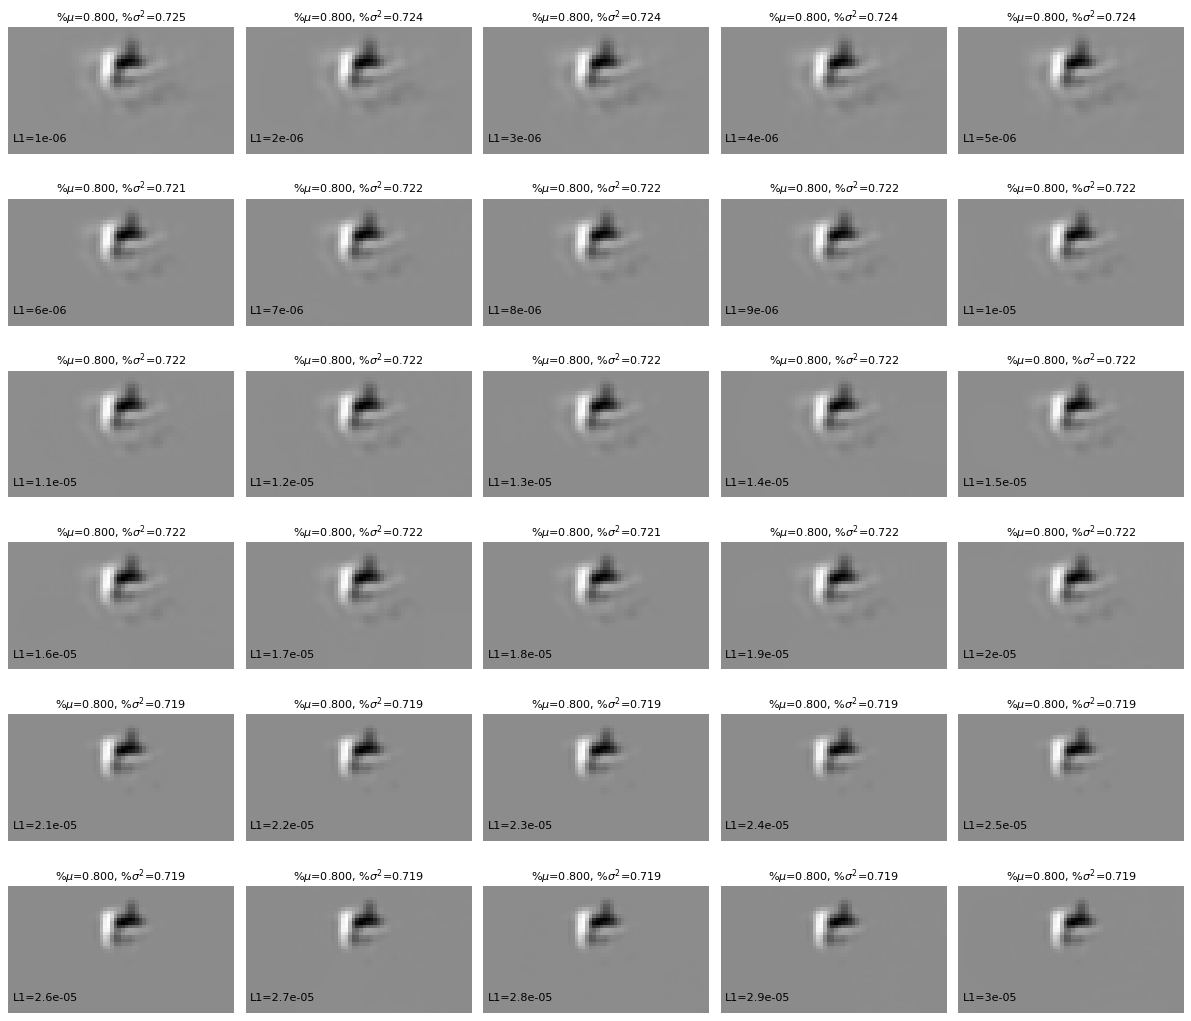

In [119]:
n_rows = 6
fig, axes = plt.subplots(n_rows, 5, figsize=(15, 2.2*n_rows), dpi=80)
fontsize = 10

dat = data.loc[(data["unit_id"] == 87) & (data["l1"] < 3.1e-5)].reset_index()

for i, ax in enumerate(axes.flatten()):
    ax.imshow(dat["mei"][i].squeeze(), cmap="gray")
    ax.axis("off")
    ax.set_title(r"%$\mu$={:.3f}, %$\sigma^2$={:.3f}".format(dat["mean"][i]/dat["mei_mean"][i], dat["variance"][i]/dat["mei_variance"][i]), fontsize=fontsize)
    ax.text(0.02, .1, "L1=" + str(dat["l1"][i]), fontsize=fontsize, transform=ax.transAxes)
fig.tight_layout()
# fig.savefig("Post-optimization of CEIs (0.8) created with different L1 weights, CEI examples" + ".png", bbox_inches="tight", transparent=False)

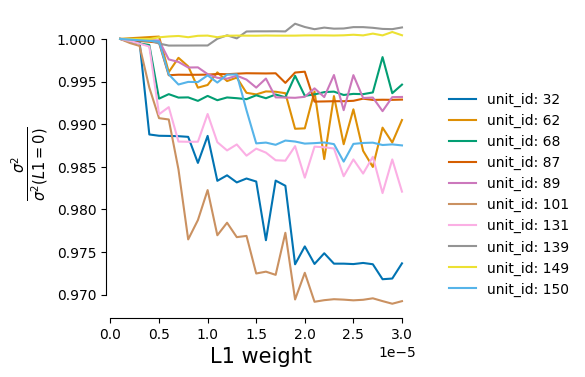

In [120]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=100)
fontsize = 15
unit_ids = np.unique(data["unit_id"])

from matplotlib.colors import ListedColormap
my_cmap = sns.color_palette("colorblind").as_hex()


for i, unit_id in enumerate(unit_ids):
    dat = data.loc[(data["unit_id"] == unit_id) & (data["l1"] < 3.1e-5)].reset_index()
    ax.plot(dat["l1"], dat["variance"]/dat["variance"][0], label=f"unit_id: {unit_id}", color=my_cmap[i])

plt.xlabel('L1 weight', fontsize=fontsize)
plt.ylabel(r"$\frac{\sigma^2}{\sigma^2(L1=0)}$", fontsize=fontsize)

ax.legend(frameon=False, bbox_to_anchor=(1.3, 0.4), loc="center")
ax.ticklabel_format(axis="x", style='scientific', scilimits=(0,0))
sns.despine(trim=True)
# fig.savefig("Post-optimization of CEIs (0.8) created with different L1 weights, L1 vs variance" + ".png", bbox_inches="tight", transparent=False)

#### Many neurons

In [40]:
experiment_name = "Post-optimization of CEIs (0.8) created with different L1 weights, many neurons"
table = MEI() & (MEIExperimentsMouse.Restrictions() & f"experiment_name = '{experiment_name}'")
score, mean, variance, method_config, unit_id, mei = table.load_data(["score", "mean", "variance", "method_config", "unit_id", "mei"])
mei = [element for element in mei]
l1 = np.array([dictionary["initial"]["kwargs"]["l1"] for dictionary in method_config])

data_cei = pd.DataFrame.from_dict({"score": score, "mean": mean, "variance": variance, "l1": l1, "unit_id": unit_id, "mei": mei})

# Get MEI data
key = table.proj().fetch(as_dict=True)
for k in key:
    k["method_hash"] = '54f863f93364931f53ecdfe7c2bc5a03'
mei_mean, mei_variance, unit_id = (MEI() & key).fetch("mean", "variance", "unit_id")
data_mei = pd.DataFrame.from_dict({"mei_mean": mei_mean, "mei_variance": mei_variance, "unit_id": unit_id})

data = pd.merge(data_mei, data_cei, on="unit_id")
data.sort_values(["unit_id", "l1"], ignore_index=True, inplace=True)

100% 6250/6250 [00:01<00:00, 5439.91it/s]


In [86]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

slopes = []
for unit_id in np.unique(data["unit_id"]):
    dat = data.loc[data["unit_id"] == unit_id]
    slope = lin_reg.fit(dat[['l1']].values, dat[['variance']].values).coef_.item()
    slopes.append(slope)

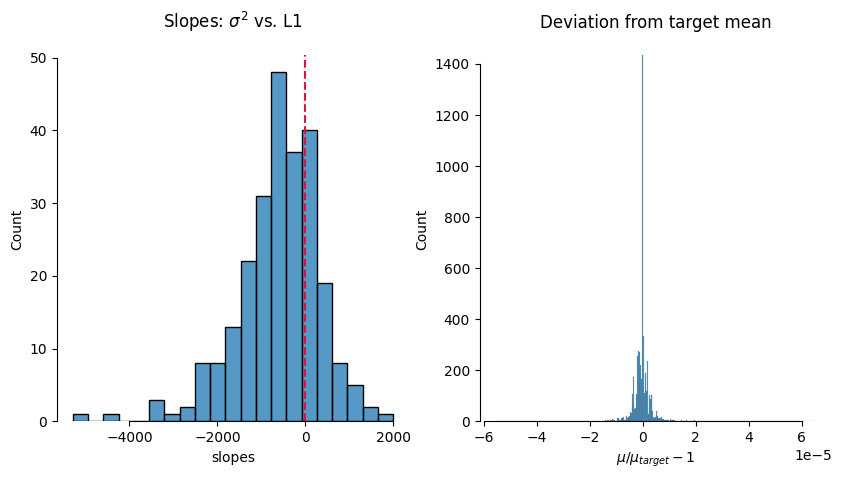

In [99]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Distribution of sopes
sns.histplot(slopes, ax=ax[0])
ax[0].set(xlabel="slopes", title=r"Slopes: $\sigma^2$ vs. L1")
ax[0].vlines(0, ax[0].get_ylim()[0], ax[0].get_ylim()[1], ls="--", color="crimson")

# Deviation from target mean
x = data["mean"]/(0.8*data["mei_mean"]) -1
sns.histplot(x, ax=ax[1])
ax[1].ticklabel_format(axis="x", style='scientific', scilimits=(0,0))
ax[1].set(xlabel=r"$\mu/\mu_{target} - 1$", title="Deviation from target mean")

sns.despine(trim=True)
# fig.savefig("Post-optimization of CEIs (0.8) created with different L1 weights, many neurons" + ".png", bbox_inches="tight", transparent=False)

___

## VEI Experiment

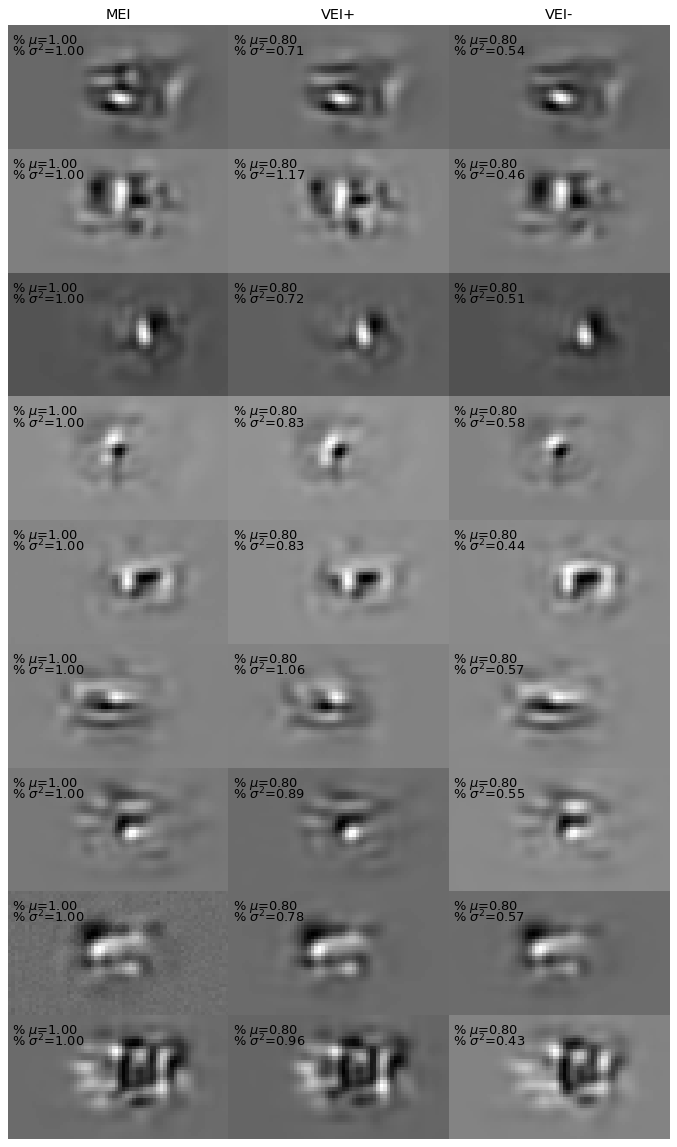

In [31]:
experiment_name = "Zhiwei0, alternative ensemble, OneValue init"
model_types = ["MEI", "VEI+", "VEI-"]


if "Monkey" in experiment_name:
    ratio = 1
    mei_table = MEIMonkey
    experiment_table = MEIExperimentsMonkey
    dpi=130
else:
    ratio = 64/36
    mei_table = MEI
    experiment_table = MEIExperimentsMouse
    dpi = 80
    
data_table = mei_table() * MEIMethod & (experiment_table.Restrictions() & f"experiment_name = '{experiment_name}'")
finished_unit_ids = np.unique(data_table.fetch("unit_id"))
ensemble_comment = np.unique((data_table * TrainedEnsembleModel).fetch("ensemble_comment")).item()

fig, axes = plt.subplots(len(finished_unit_ids), len(model_types), figsize=(2*ratio*len(model_types), 2*len(finished_unit_ids)+.3), dpi=dpi)
fontsize = 13

for i in range(len(finished_unit_ids)):
    for j, mei_type in enumerate(model_types):
        method_restr = f"method_comment like '%{mei_type}%'"
        table = (data_table & f"unit_id = {finished_unit_ids[i]}" & method_restr)
        mei_path, mean, variance = table.fetch1("mei", "mean", "variance")
        if mei_type == "MEI":
            mei_mean = mean
            mei_variance = variance
        mei = load(mei_path)
        os.remove(mei_path)
        axes[i, j].imshow(mei.squeeze(), cmap="gray")
        axes[i, j].axis("off")
        axes[i, j].text(0.02,
                        .85,
                        r"% $\mu$={:.2f}".format(mean/mei_mean),
                        horizontalalignment='left', 
                        transform=axes[i, j].transAxes,
                        fontsize=fontsize*.9)
        axes[i, j].text(0.02,
                        .75,
                        r"% $\sigma^2$={:.2f}".format(variance/mei_variance),
                        horizontalalignment='left', 
                        transform=axes[i, j].transAxes,
                        fontsize=fontsize*.9)
        if i == 0:
            axes[i, j].set_title(mei_type, fontsize=fontsize)
fig.subplots_adjust(wspace=0, hspace=-.1)
# fig.savefig(experiment_name + ".png", bbox_inches="tight", transparent=False)

##### Difference between VEIs

In [ ]:
data = np.empty((10, 3, 36, 64))*np.nan
for i in range(len(fig.axes)):
    x = np.ma.getdata(fig.axes[i].get_images()[0].get_array())
    data[i//3, i%3, :, :] = x

In [ ]:
fig2, axes = plt.subplots(data.shape[0], 4, figsize=(10, 15), dpi=100)
fontsize = 10
for i, x in enumerate(data):
    axes[i, 0].imshow(x[0], cmap="gray")
    axes[i, 1].imshow(x[1], cmap="gray")
    axes[i, 2].imshow(x[2], cmap="gray")
    axes[i, 3].imshow(x[1]-x[2], cmap="gray")
    axes[i, 0].axis("off")
    axes[i, 1].axis("off")
    axes[i, 2].axis("off")
    axes[i, 3].axis("off")
axes[0, 0].set_title("MEI", fontsize=fontsize)
axes[0, 1].set_title("VEI+", fontsize=fontsize)
axes[0, 2].set_title("VEI-", fontsize=fontsize)
axes[0, 3].set_title("DIFF(VEIs)", fontsize=fontsize)
# fig2.savefig("diff_of_veis" + ".png", bbox_inches="tight", transparent=False)

## Norm comparison

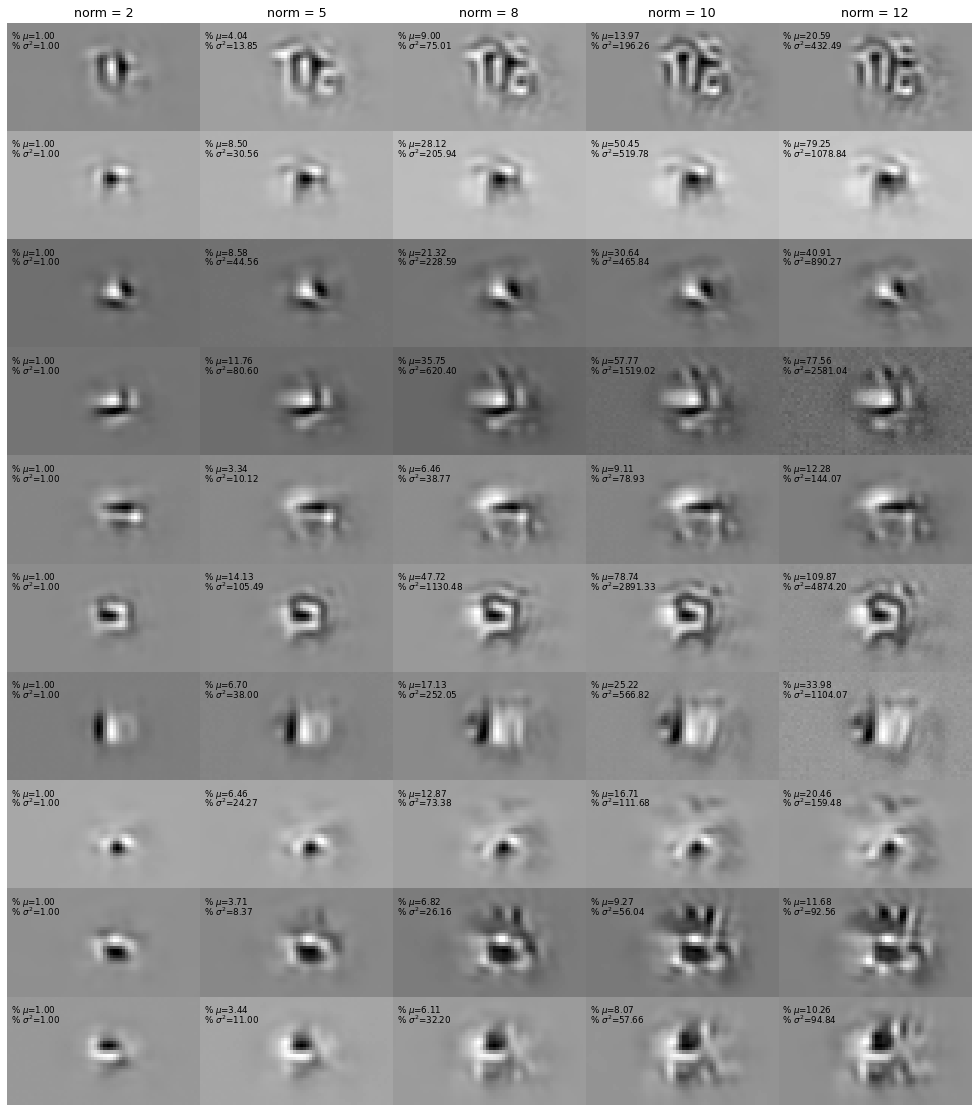

In [57]:
experiment_name = "Mouse V1, MEIs with different norm, gamma models"

data_table = mei_table() * MEIMethod & (experiment_table.Restrictions() & f"experiment_name = '{experiment_name}'")
finished_unit_ids = np.unique(data_table.fetch("unit_id"))
ensemble_comment = np.unique((data_table * TrainedEnsembleModel).fetch("ensemble_comment")).item()
methods = ['MEI, norm=2', 'MEI, norm=5', 'MEI, norm=8', 'MEI', 'MEI, norm=12']

fig, axes = plt.subplots(len(finished_unit_ids), 5, figsize=(2*ratio*5, 2*len(finished_unit_ids)+.3), dpi=70)
fontsize = 10

for i in range(len(finished_unit_ids)):
    for j, method in enumerate(methods):
        method_restr = f"method_comment = '{method}'"
        table = (data_table & f"unit_id = {finished_unit_ids[i]}" & method_restr)
        mei_path, mean, variance = table.fetch1("mei", "mean", "variance")
        norm = table.fetch1("method_config")["postprocessing"]["kwargs"]["norm"]
        
        if method == methods[0]:
            mei_mean = mean
            mei_variance = variance
        mei = load(mei_path)
        os.remove(mei_path)
        axes[i, j].imshow(mei.squeeze(), cmap="gray")
        axes[i, j].axis("off")
        axes[i, j].text(0.02,
                        .85,
                        r"% $\mu$={:.2f}".format(mean/mei_mean),
                        horizontalalignment='left', 
                        transform=axes[i, j].transAxes,
                        fontsize=fontsize*.9)
        axes[i, j].text(0.02,
                        .75,
                        r"% $\sigma^2$={:.2f}".format(variance/mei_variance),
                        horizontalalignment='left', 
                        transform=axes[i, j].transAxes,
                        fontsize=fontsize*.9)
        if i == 0:
            axes[i, j].set_title(f"norm = {norm}", fontsize=fontsize*1.3)
fig.subplots_adjust(wspace=0, hspace=-.1)
# fig.savefig(ensemble_comment + "_norm_comparison" + ".png", bbox_inches="tight", transparent=False)

___